# Data exploration

## Preliminaries

### Imports

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
matplotlib.rcParams.update({'font.size': 16})

In [5]:
from transformers import AutoTokenizer

In [6]:
from programmable_chatbot.data.corpus import CORPORA

In [7]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/vincenzo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

### Constants

In [9]:
RAW_DATA_PATH = '../resources/data/raw'

In [10]:
SPLITS = ('train', 'validation', 'test')

In [11]:
RANDOM_SEED = 2307

In [12]:
CORPUS_KWARGS = {
    'Counseling_and_Psychotherapy_Transcripts_Volume_II': {'holdout': 50}
}

In [13]:
DF_COLUMNS = ['corpus_id', 'split', 'dialogue_id', 'utterance_id', 'speaker', 'n_tokens']

In [14]:
OPEN_DOMAIN_DATA = ('dailydialog', 'empatheticdialogues', 'IEMOCAP_full_release', 'personachat', 'Topical-Chat-master', 'wizard_of_wikipedia')
THERAPY_DATA = ('Counseling_and_Psychotherapy_Transcripts_Volume_II', 'HOPE_WSDM_2022', 'Counsel_Chat', 'Empathy-Mental-Health-master')

In [15]:
UNCERTAINTY = False

In [16]:
COLUMNS_DD_LOCAL = ['Split', 'Emotion', 'Dialogue act']
COLUMNS_DD_GLOBAL = ['Split', 'Topic']

In [17]:
COLUMNS_IEMOCAP = ['Split', 'Emotion', 'Valence', 'Activation', 'Dominance']
COLUMNS_IEMOCAP_EXTENDED = ['Split', 'File path', 'Emotion', 'Valence', 'Activation', 'Dominance']
COL_ORDER_I_V = [val.capitalize() for val in ['very negative', 'negative', 'neutral', 'positive', 'very positive'][::-1]]
COL_ORDER_I_A = [val.capitalize() for val in ['very low', 'low', 'medium', 'high', 'very high'][::-1]]
COL_ORDER_I_D = [val.capitalize() for val in ['very weak', 'weak', 'medium', 'strong', 'very strong'][::-1]]
COL_ORDER_I_LIST = [COL_ORDER_I_V, COL_ORDER_I_A, COL_ORDER_I_D]

In [18]:
COLUMNS_HOPE = ['Split', 'Speaker', 'Dialogue act', 'Dialogue act category']
HUE_ORDER_HOPE = ['Therapist', 'Patient']

In [19]:
COLUMNS_EPITOME = ['Split', 'Emotional reaction', 'Exploration', 'Interpretation']
COL_ORDER_E = [val.capitalize() for val in ['no communication', 'weak communication', 'strong communication'][::-1]]

### Helper functions

In [20]:
def preprocess_metadata(s: str) -> str:
    return s.capitalize().replace('_', ' ')

def get_metadata_column_id(s: str) -> str:
    return s.lower().replace(' ', '_')

### Global variables

In [21]:
gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2')

## Data

Load data sets into dictionary.

In [22]:
data = {
    corpus_id: {
        split: CORPORA[corpus_id](
            os.path.join(RAW_DATA_PATH, corpus_id),
            split,
            gpt2_tokenizer,
            random_seed=RANDOM_SEED,
            **CORPUS_KWARGS.get(corpus_id, dict())
        ).data
        for split in SPLITS
    }
    for corpus_id in CORPORA
}

/home/vincenzo/Documents/programmable_chatbot/src/programmable_chatbot/data/corpora.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['level_er', 'rationales_er']] = df_er[['level', 'rationales']]
/home/vincenzo/Documents/programmable_chatbot/src/programmable_chatbot/data/corpora.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['level_er', 'rationales_er']] = df_er[['level', 'rationales']]
/home/vincenzo/Documents/programmable_chatbot/src/programmable_chatbot/data/corpora.py:1835: Setting

Extract info and convert to data frame

In [23]:
df = pd.DataFrame(
    [
        (corpus, split, i, j, utterance.get('speaker'), len(word_tokenize(utterance['text'])))
        for corpus, splits in data.items()
        for split, dialogues in splits.items()
        for i, dialogue in enumerate(dialogues)
        for j, utterance in enumerate(dialogue['utterances'])
    ],
    columns=DF_COLUMNS
)

### Exploration

Compute data set stats

In [52]:
for split in SPLITS:
    for corpus in OPEN_DOMAIN_DATA:
        tmp_df = df[(df['split'] == split) & (df['corpus_id'] == corpus)]
        print(
            f"{tmp_df['dialogue_id'].nunique():d}",
            f"{tmp_df.groupby('dialogue_id', sort=False).size().reset_index()[0].mean():.1f}" + (f" \pm {tmp_df.groupby('dialogue_id', sort=False).size().reset_index()[0].std():.1f}" if UNCERTAINTY else "") ,
            f"{tmp_df['n_tokens'].mean():.1f}" + (f" \pm {tmp_df['n_tokens'].std():.1f}" if UNCERTAINTY else ""),
            sep=' & '
        )

11118 & 7.8 & 14.0
19533 & 4.3 & 15.6
84 & 64.0 & 14.8
8939 & 14.7 & 11.7
8628 & 21.8 & 22.6
18430 & 9.0 & 18.9
1000 & 8.1 & 13.9
2770 & 4.4 & 16.7
29 & 72.7 & 14.5
1000 & 15.6 & 11.9
1078 & 21.7 & 22.7
981 & 9.1 & 18.9
1000 & 7.7 & 14.2
2547 & 4.3 & 17.8
38 & 67.2 & 15.0
968 & 15.5 & 11.8
1078 & 21.8 & 22.6
965 & 9.0 & 18.9


In [53]:
for split in SPLITS:
    for corpus in THERAPY_DATA:
        tmp_df = df[(df['split'] == split) & (df['corpus_id'] == corpus)]
        tmp_df_t = tmp_df[tmp_df['speaker'] == 'therapist']
        tmp_df_p = tmp_df[tmp_df['speaker'] == 'patient']
        print(
            f"{tmp_df['dialogue_id'].nunique():d}",
            f"{tmp_df.groupby('dialogue_id', sort=False).size().reset_index()[0].mean():.1f}" + (f" \pm {tmp_df.groupby('dialogue_id', sort=False).size().reset_index()[0].std():.1f}" if UNCERTAINTY else "") ,
            f"{tmp_df['n_tokens'].mean():.1f}" + (f" \pm {tmp_df['n_tokens'].std():.1f}" if UNCERTAINTY else ""),
            f"{tmp_df_t['n_tokens'].mean():.1f}" + (f" \pm {tmp_df_t['n_tokens'].std():.1f}" if UNCERTAINTY else ""),
            f"{tmp_df_p['n_tokens'].mean():.1f}" + (f" \pm {tmp_df_p['n_tokens'].std():.1f}" if UNCERTAINTY else ""),
            sep=' & '
        )

1578 & 148.8 & 40.8 & 21.0 & 60.2
149 & 63.2 & 26.5 & 28.3 & 24.7
1379 & 2.0 & 117.9 & 163.0 & 72.8
1734 & 2.0 & 48.3 & 56.6 & 40.0
50 & 152.5 & 39.3 & 19.0 & 59.2
21 & 56.9 & 27.6 & 29.2 & 25.9
460 & 2.0 & 117.9 & 160.8 & 74.9
579 & 2.0 & 47.0 & 52.0 & 42.0
50 & 148.9 & 37.1 & 22.8 & 51.2
42 & 53.4 & 27.5 & 25.8 & 29.3
173 & 2.0 & 122.8 & 169.1 & 76.5
771 & 2.0 & 45.8 & 50.3 & 41.4


### Visualisation

#### DailyDialog

In [62]:
tmp_df = pd.DataFrame(
    [
        (split.capitalize(), *(preprocess_metadata(utterance[get_metadata_column_id(label)]) for label in COLUMNS_DD_LOCAL[1:]))
        for split, dialogues in data['dailydialog'].items()
        for dialogue in dialogues
        for utterance in dialogue['utterances']
    ],
    columns=COLUMNS_DD_LOCAL
)

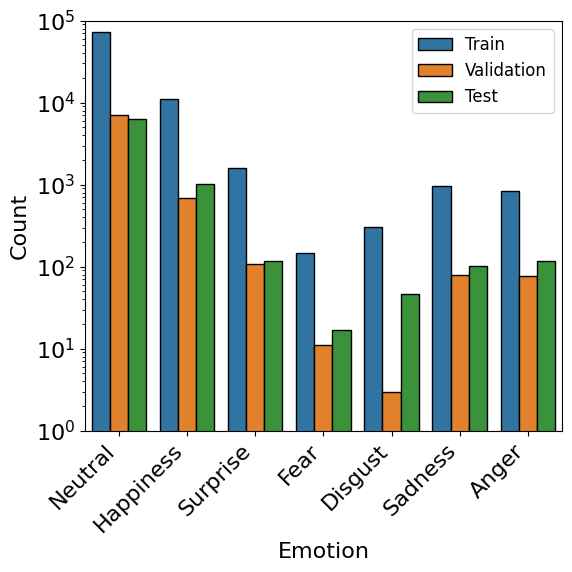

In [63]:
fig = plt.figure(figsize=(6, 6))
sns.countplot(data=tmp_df, x='Emotion', hue='Split', linewidth=1., edgecolor='0')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylim([1, 1e5])
plt.ylabel('Count')
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

In [64]:
fig.savefig('ddemo.pdf', bbox_inches='tight')

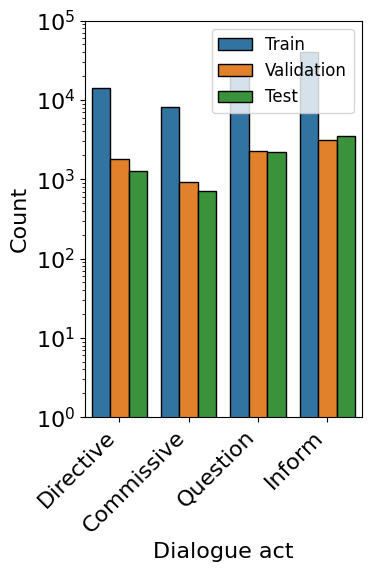

In [65]:
fig = plt.figure(figsize=(4, 6))
sns.countplot(data=tmp_df, x='Dialogue act', hue='Split', linewidth=1., edgecolor='0')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylim([1, 1e5])
plt.legend(loc='best', fontsize=12)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [66]:
fig.savefig('ddda.pdf', bbox_inches='tight')

In [67]:
tmp_df = pd.DataFrame(
    [
        (split.capitalize(), *(preprocess_metadata(dialogue[get_metadata_column_id(label)]) for label in COLUMNS_DD_GLOBAL[1:]))
        for split, dialogues in data['dailydialog'].items()
        for dialogue in dialogues
    ],
    columns=COLUMNS_DD_GLOBAL
)

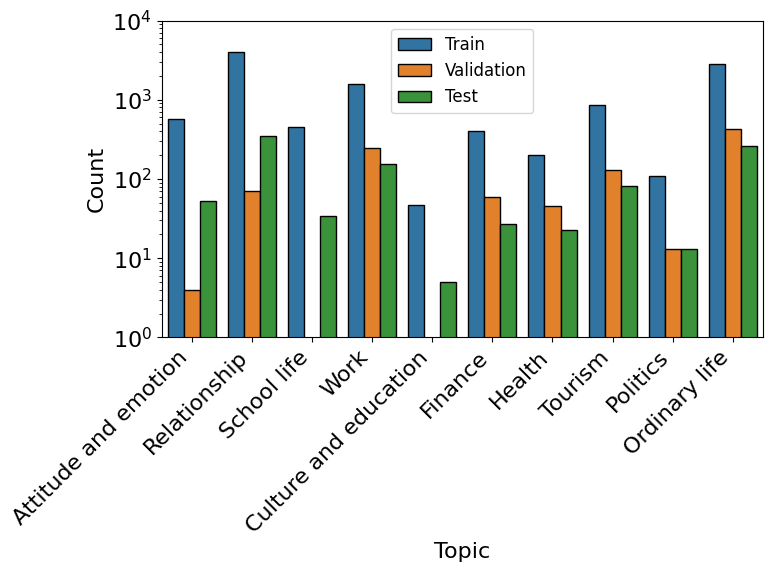

In [68]:
fig = plt.figure(figsize=(8, 6))
sns.countplot(data=tmp_df, x='Topic', hue='Split', linewidth=1., edgecolor='0')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylim([1, 1e4])
plt.ylabel('Count')
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

In [69]:
fig.savefig('ddtopic.pdf', bbox_inches='tight')

#### IEMOCAP

##### Text

In [70]:
tmp_df = pd.DataFrame(
    [
        (split.capitalize(), *(preprocess_metadata(utterance[get_metadata_column_id(label)]) for label in COLUMNS_IEMOCAP[1:]))
        for split, dialogues in data['IEMOCAP_full_release'].items()
        for dialogue in dialogues
        for utterance in dialogue['utterances']
    ],
    columns=COLUMNS_IEMOCAP
)

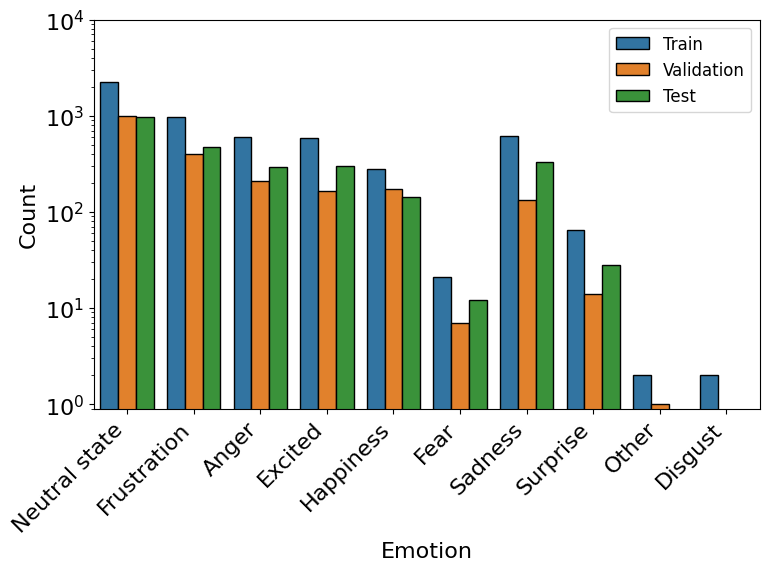

In [71]:
fig = plt.figure(figsize=(8, 6))
sns.countplot(data=tmp_df, x='Emotion', hue='Split', linewidth=1., edgecolor='0')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylim([0.9, 1e4])
plt.ylabel('Count')
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

In [47]:
fig.savefig('iemocapemocat.pdf', bbox_inches='tight')

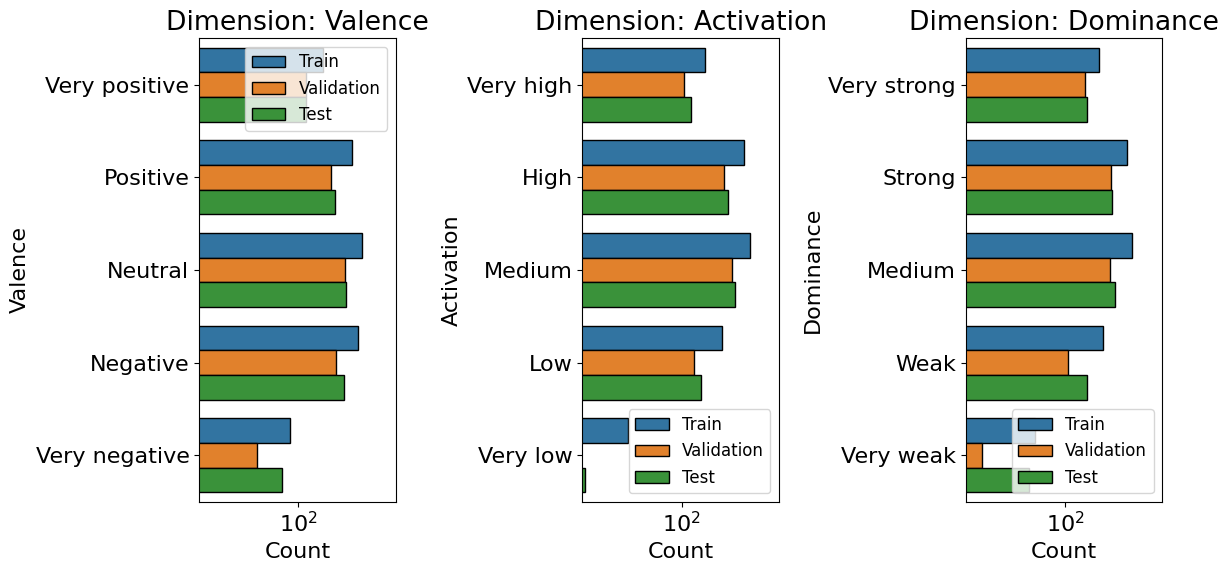

In [74]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(12,6),
    sharex=True
)

for i, (label, label_order) in enumerate(zip(COLUMNS_IEMOCAP[-3:], COL_ORDER_I_LIST)):
    sns.countplot(
        data=tmp_df, hue='Split', y=label, order=label_order, ax=axes[i], linewidth=1., edgecolor='0', orient='h'
    )
    axes[i].set_title(f'Dimension: {label}')
    axes[i].set_xscale('log')
    axes[i].set_xlim([0.9, 1e4])
    axes[i].set_xlabel('Count')
    axes[i].legend(loc='best', fontsize=12)

plt.tight_layout()
plt.show()

In [49]:
fig.savefig('iemocapemodim.pdf', bbox_inches='tight')

##### Speech

In [96]:
tmp_df = pd.DataFrame(
    [
        (split.capitalize(), utterance['audio_file'], *(preprocess_metadata(utterance[get_metadata_column_id(label)]) for label in COLUMNS_IEMOCAP_EXTENDED[2:]))
        for split, dialogues in data['IEMOCAP_full_release'].items()
        for dialogue in dialogues
        for utterance in dialogue['utterances']
    ],
    columns=COLUMNS_IEMOCAP_EXTENDED
)

In [97]:
len(tmp_df)

10039

In [89]:
import pickle
import bz2

cache_path = '/home/vincenzo/Documents/gsttransformer/resources/data/cache'
mellotron_cache = []

for file_name in os.listdir(cache_path):
    if file_name.endswith('.pbz2'):
        with bz2.BZ2File(os.path.join(cache_path, file_name), 'r') as f:
            mellotron_cache += pickle.load(f)
mellotron_cache = {
    sample['audio_file_path']: {
        'gst_embeddings': sample['gst_embeddings'].reshape(-1),
        'gst_scores': sample['gst_scores'].reshape(-1)
    }
    for sample in mellotron_cache if not isinstance(sample, str)
}

In [90]:
len(mellotron_cache)

7396

In [95]:
mellotron_cache['IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M000.wav'].keys()

dict_keys(['gst_embeddings', 'gst_scores'])

In [98]:
tsne_gst_embeds = np.array([mellotron_cache[row['File path']]['gst_embeddings'] for _, row in tmp_df.iterrows() if row['File path'] in mellotron_cache])
tsne_gst_weights = np.array([mellotron_cache[row['File path']]['gst_scores'] for _, row in tmp_df.iterrows() if row['File path'] in mellotron_cache])

In [99]:
tsne_gst_embeds = TSNE().fit_transform(StandardScaler().fit_transform(tsne_gst_embeds))
tsne_gst_weights = TSNE().fit_transform(StandardScaler().fit_transform(tsne_gst_weights))

In [100]:
tmp_df_ = tmp_df[tmp_df['File path'].isin(mellotron_cache)]
len(tmp_df_)

7396

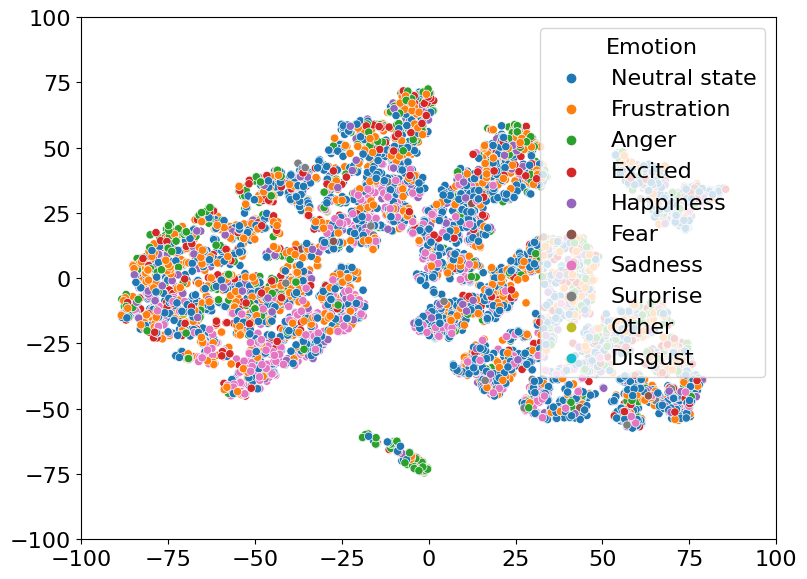

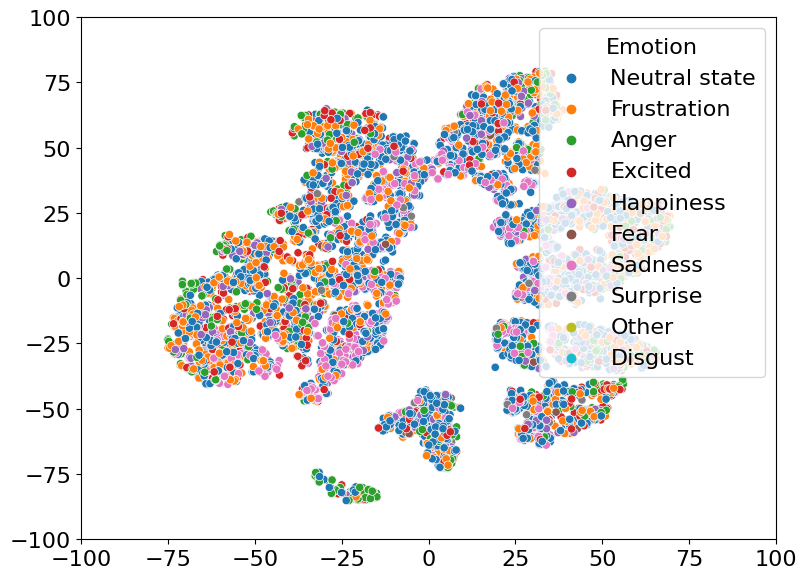

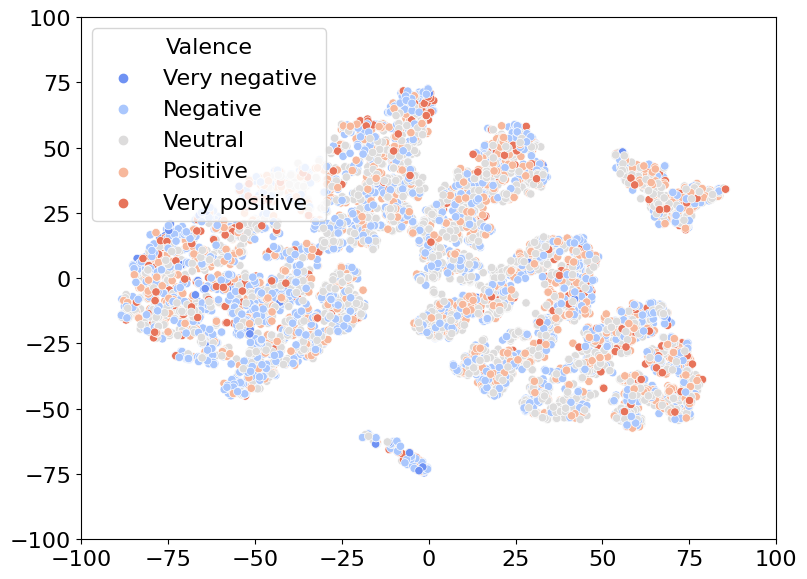

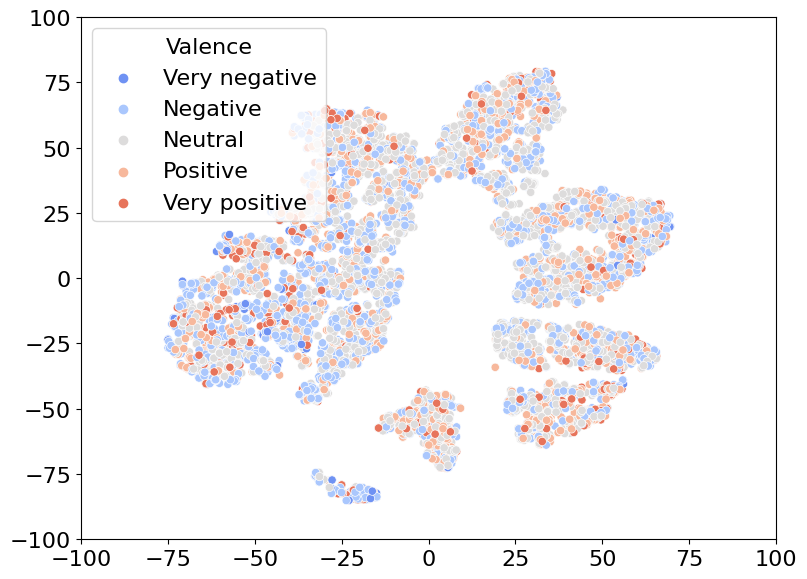

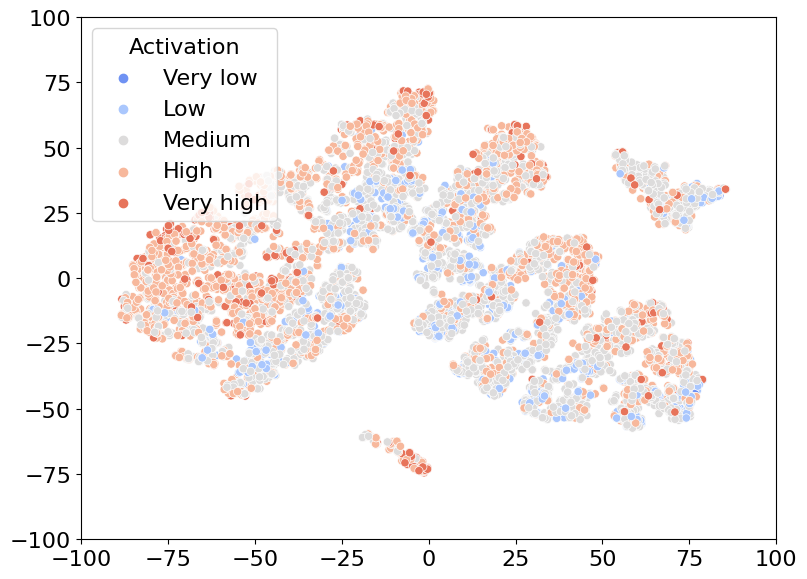

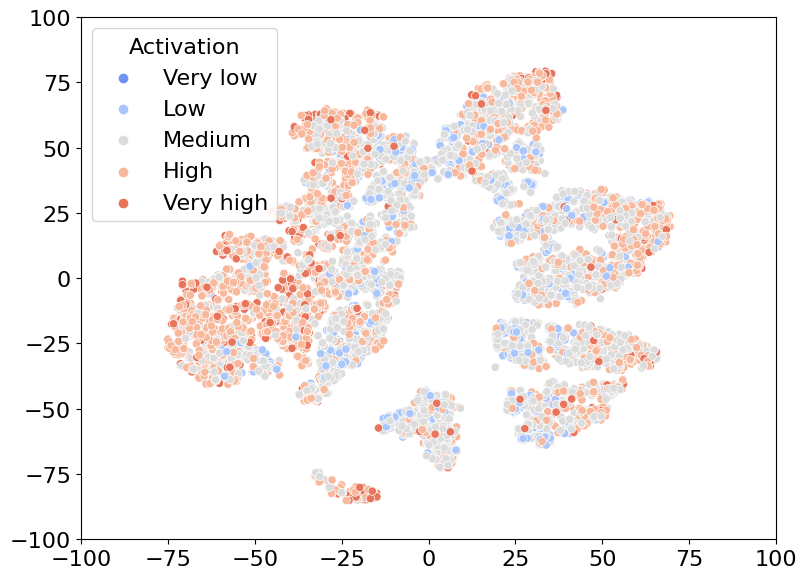

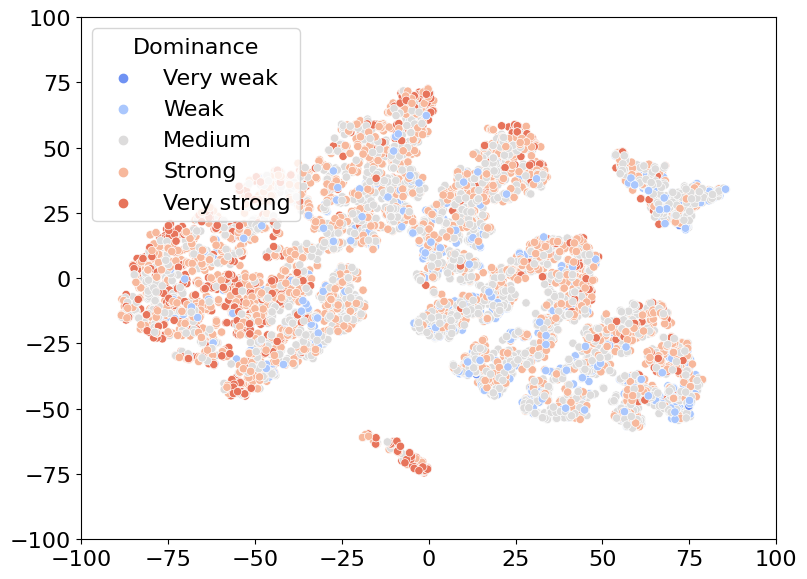

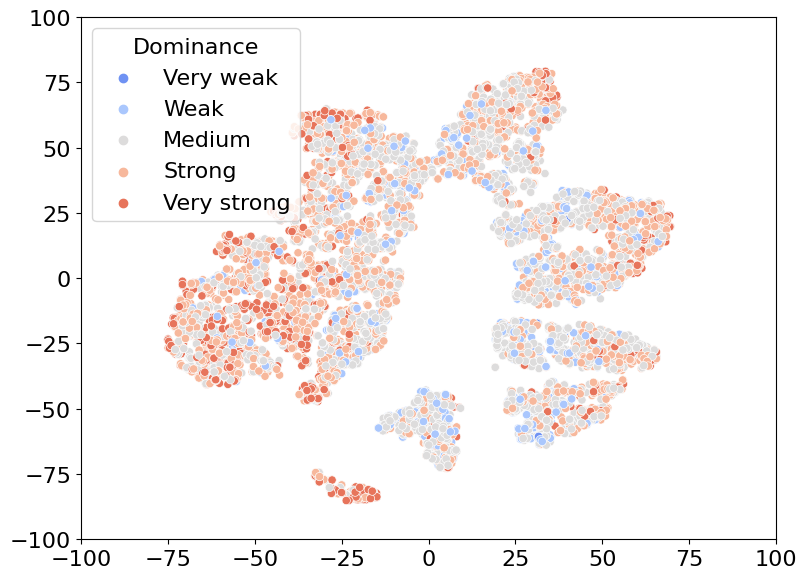

In [113]:
for label, order in zip(COLUMNS_IEMOCAP[-4:], [None] + COL_ORDER_I_LIST):
    if order is not None:
        order = order[::-1]
    for embeds_id, embeds in zip(('gstembeds', 'gstweights'), (tsne_gst_embeds, tsne_gst_weights)):
        fig = plt.figure(figsize=(8, 6))
        if order is not None:
            s = sns.scatterplot(x=embeds[:, 0], y=embeds[:, 1], hue=tmp_df_[label], hue_order=order, palette="coolwarm")
        else:
            s = sns.scatterplot(x=embeds[:, 0], y=embeds[:, 1], hue=tmp_df_[label])
        
        plt.tight_layout()
        plt.xlim([-100, 100])
        plt.ylim([-100, 100])
        plt.show()
        
        fig.savefig(f'iemocapapeech{label.lower()}{embeds_id}.pdf', bbox_inches='tight')

#### HOPE

In [75]:
tmp_df = pd.DataFrame(
    [
        (split.capitalize(), *(preprocess_metadata(utterance[get_metadata_column_id(label)]) if utterance[get_metadata_column_id(label)] is not None else None for label in COLUMNS_HOPE[1:]))
        for split, dialogues in data['HOPE_WSDM_2022'].items()
        for dialogue in dialogues
        for utterance in dialogue['utterances']
    ],
    columns=COLUMNS_HOPE
)

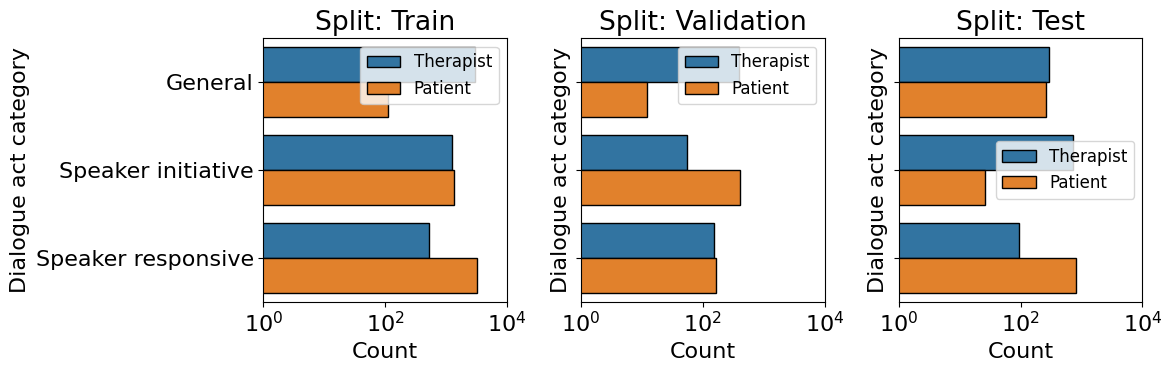

In [80]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(tmp_df['Split'].unique()),
    figsize=(12, 4),
    sharex=True,
    sharey=True
)

for i, split in enumerate(tmp_df['Split'].unique()):
    sns.countplot(
        data=tmp_df[tmp_df['Split'] == split], hue='Speaker', y='Dialogue act category', hue_order=HUE_ORDER_HOPE,
        ax=axes[i], linewidth=1., edgecolor='0', orient='h'
    )
    axes[i].set_title(f'Split: {split}')
    axes[i].set_xscale('log')
    axes[i].set_xlim([1, 1e4])
    axes[i].set_xlabel('Count')
    axes[i].legend(loc='best', fontsize=12)

plt.tight_layout()
plt.show()

In [81]:
fig.savefig('hopedac.pdf', bbox_inches='tight')

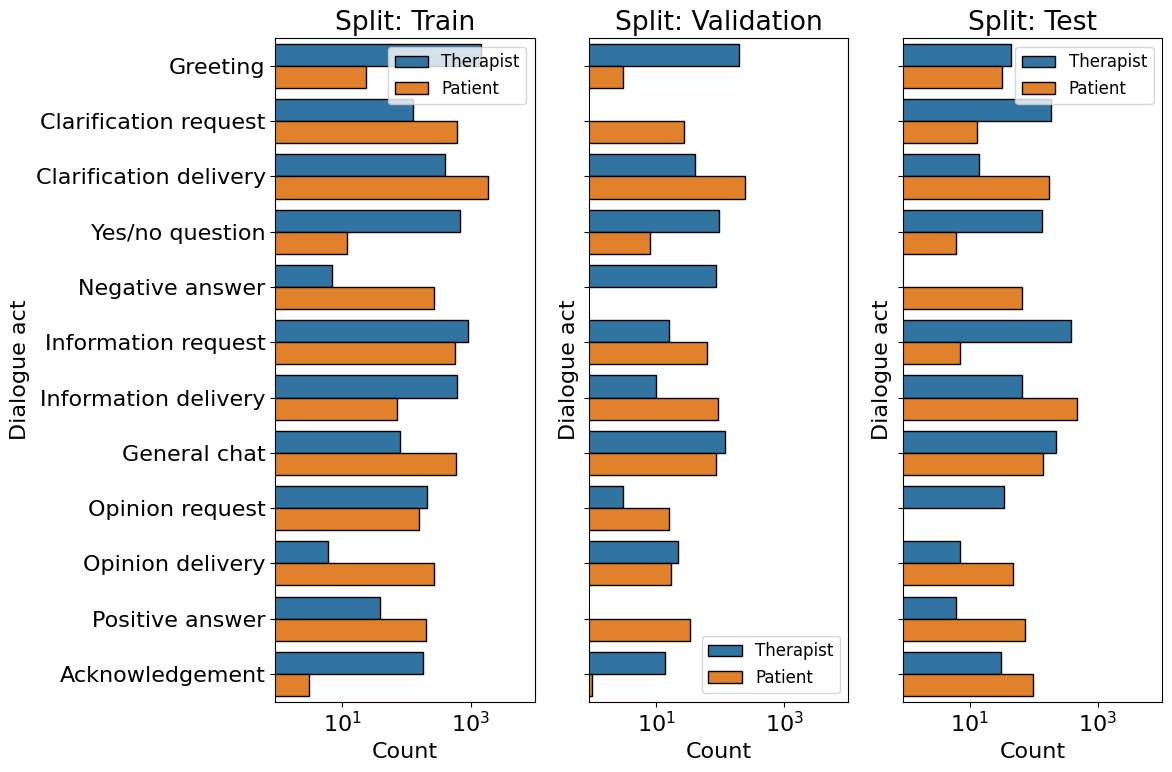

In [82]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(tmp_df['Split'].unique()),
    figsize=(12, 8),
    sharex=True,
    sharey=True
)

for i, split in enumerate(tmp_df['Split'].unique()):
    sns.countplot(
        data=tmp_df[tmp_df['Split'] == split], hue='Speaker', y='Dialogue act', hue_order=HUE_ORDER_HOPE,
        ax=axes[i], linewidth=1., edgecolor='0', orient='h'
    )
    axes[i].set_title(f'Split: {split}')
    axes[i].set_xscale('log')
    axes[i].set_xlim([0.9, 1e4])
    axes[i].set_xlabel('Count')
    axes[i].legend(loc='best', fontsize=12)

plt.tight_layout()
plt.show()

In [83]:
fig.savefig('hopeda.pdf', bbox_inches='tight')

#### EPITOME

In [84]:
tmp_df = pd.DataFrame(
    [
        (split.capitalize(), *(preprocess_metadata(dialogue['utterances'][-1][get_metadata_column_id(label)]) for label in COLUMNS_EPITOME[1:]))
        for split, dialogues in data['Empathy-Mental-Health-master'].items()
        for dialogue in dialogues
    ],
    columns=COLUMNS_EPITOME
)

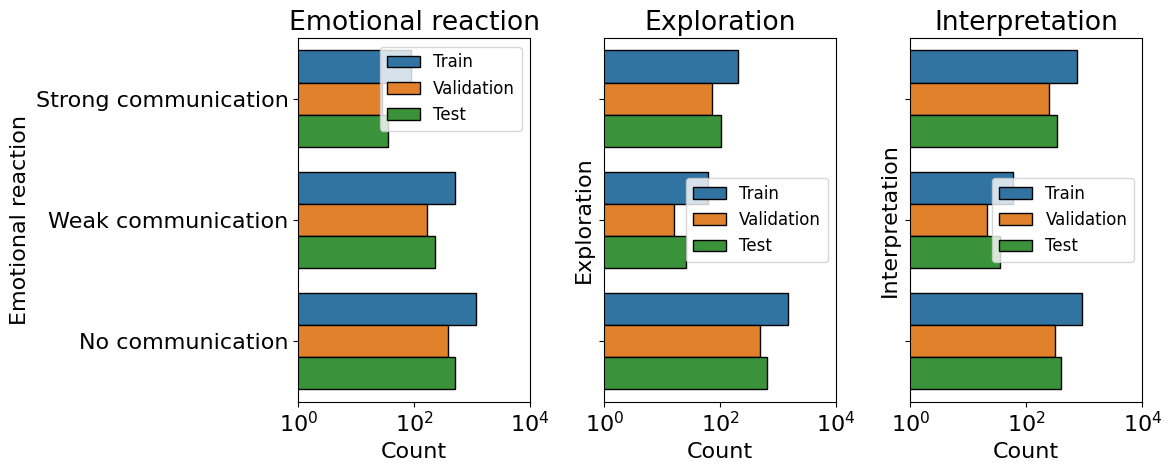

In [87]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(COLUMNS_EPITOME[1:]),
    figsize=(12, 5),
    sharex=True,
    sharey=True
)

for i, label in enumerate(COLUMNS_EPITOME[1:]):
    sns.countplot(
        data=tmp_df, hue='Split', y=label, order=COL_ORDER_E, ax=axes[i], linewidth=1., edgecolor='0', orient='h'
    )
    axes[i].set_title(label)
    axes[i].set_xscale('log')
    axes[i].set_xlim([1, 1e4])
    axes[i].set_xlabel('Count')
    axes[i].legend(loc='best', fontsize=12)

plt.tight_layout()
plt.show()

In [88]:
fig.savefig('epitomeemp.pdf', bbox_inches='tight')